In [2]:
%pip install --upgrade tensorflow

In [3]:
%pip install tensorflow_datasets

In [4]:
import tensorflow as tf
tf.__version__


2024-06-04 11:07:34.751166: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 11:07:35.944616: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 11:07:38.324831: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 11:07:41.880662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.16.1'

In [5]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3, InceptionResNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [6]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='JellyFish/train',
  labels='inferred',
  label_mode='int', # !!! ‘categorical' when using sparse_categorical_crossentropy loss !!!
  batch_size=12,
  image_size=(150, 150))

validation_ds = tf.keras.utils.image_dataset_from_directory(
  directory='JellyFish/val',
  labels='inferred',
  label_mode='int',
  batch_size=12,
  image_size=(150, 150))

Found 777 files belonging to 6 classes.
Found 123 files belonging to 6 classes.


In [7]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [8]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of training batches: 65
Number of validation batches: 9
Number of test batches: 2


2024-06-04 11:08:10.292671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


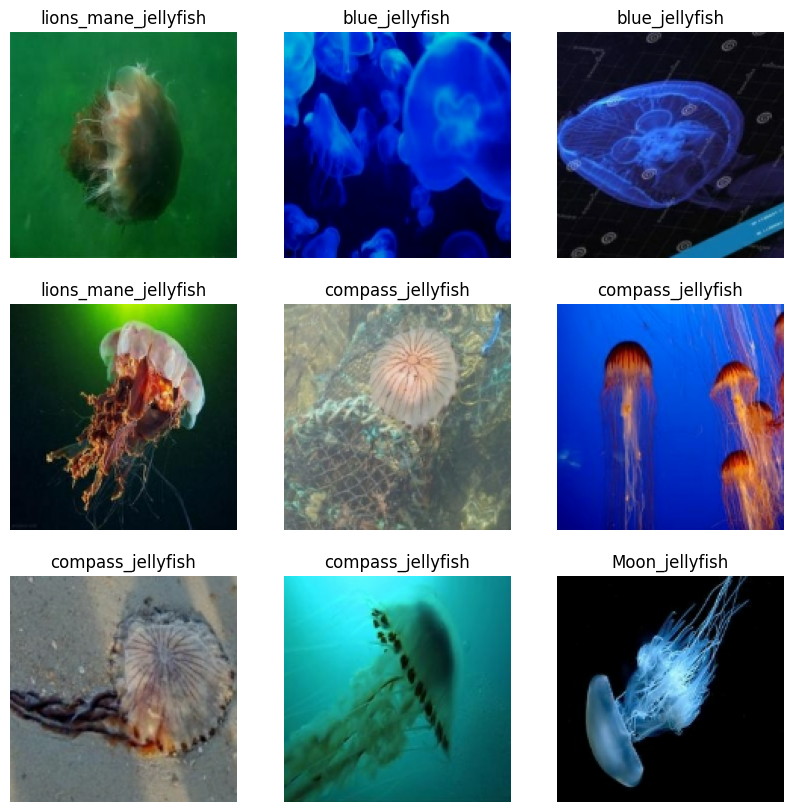

In [9]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
number_of_classes = len(train_ds.class_names)

# resize Image


In [11]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [12]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

2024-06-04 11:08:31.055241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


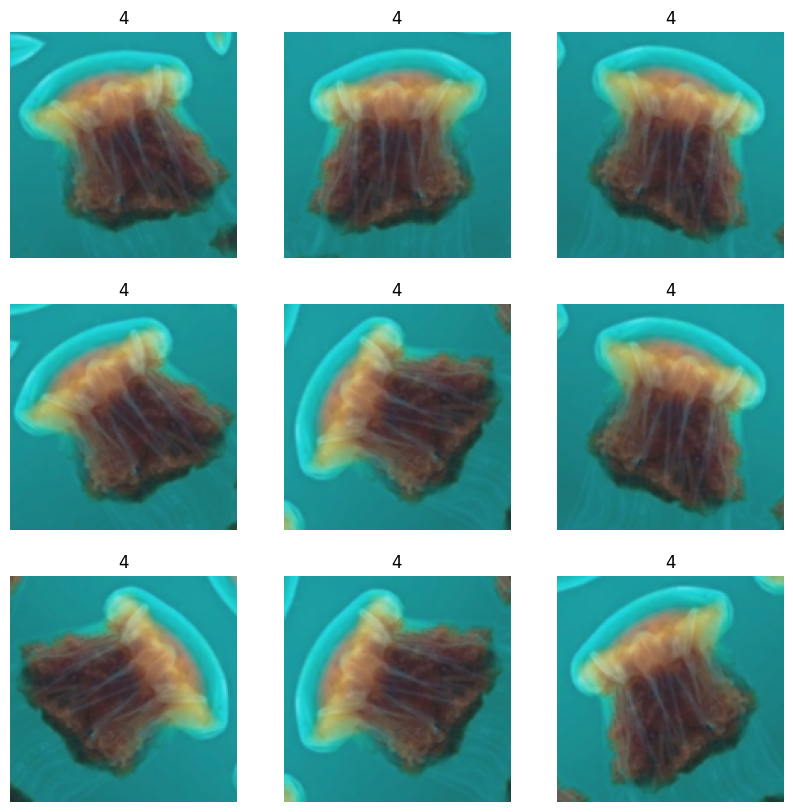

In [13]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

# InceptionResNetV2 Modell

In [14]:
# Anzahl der Klassen
number_of_classes = 6

# InceptionResNetV2 Modell laden
base_model = InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained InceptionResNetV2 weights require input normalization
# from (0, 255) to a range of (0, 1), so we add a rescaling layer
scale_layer = keras.layers.Rescaling(scale=1.0/255.0)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ inception_resnet_v2         │ (None, 3, 3, 1536)    │ 54,336,736 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1536)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1536)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 6)             │      9,222 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 54,345,958 (207.31 MB)

 Trainable params: 9,222 (36.02 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [15]:
model.compile(optimizer=keras.optimizers.Adam(),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'])

initial_epochs = 4
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/4
65/65 ━━━━━━━━━━━━━━━━━━━━ 73s 916ms/step - accuracy: 0.3156 - loss: 2.3847 - val_accuracy: 0.6263 - val_loss: 0.9735
Epoch 2/4
65/65 ━━━━━━━━━━━━━━━━━━━━ 53s 808ms/step - accuracy: 0.5790 - loss: 1.2222 - val_accuracy: 0.7273 - val_loss: 0.7532
Epoch 3/4
65/65 ━━━━━━━━━━━━━━━━━━━━ 52s 801ms/step - accuracy: 0.6293 - loss: 1.0049 - val_accuracy: 0.7677 - val_loss: 0.6502
Epoch 4/4
65/65 ━━━━━━━━━━━━━━━━━━━━ 57s 873ms/step - accuracy: 0.7186 - loss: 0.7877 - val_accuracy: 0.7677 - val_loss: 0.6687


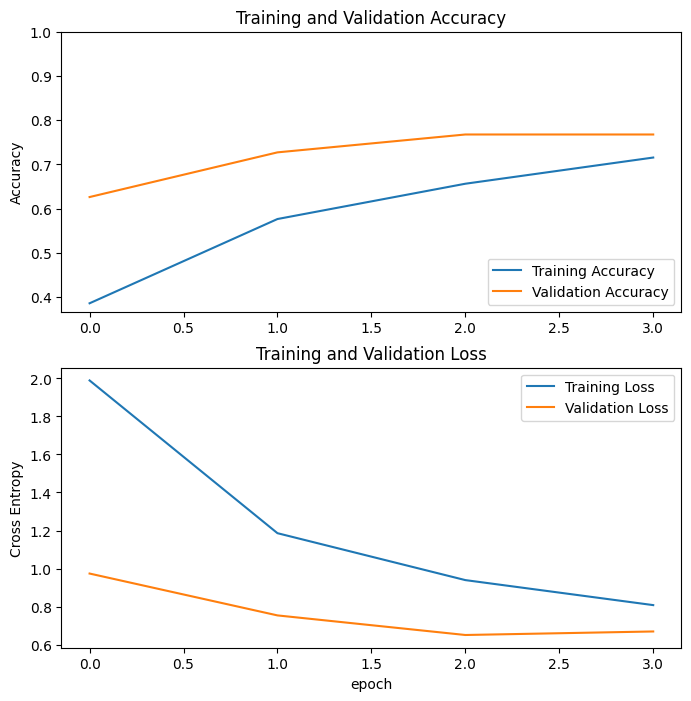

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

epochs = 1
print("Fitting the end-to-end model")
history_fine = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ inception_resnet_v2         │ (None, 3, 3, 1536)    │ 54,336,736 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1536)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1536)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 6)             │      9,222 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 54,364,404 (207.38 MB)

 Trainable params: 54,285,414 (207.08 MB)

 Non-trainable params: 60,544 (236.50 KB)

 Optimizer params: 18,446 (72.06 KB)

Fitting the end-to-end model


2024-06-04 11:14:52.416673: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23298048 exceeds 10% of free system memory.
2024-06-04 11:14:52.423149: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25886720 exceeds 10% of free system memory.
2024-06-04 11:14:52.428521: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25886720 exceeds 10% of free system memory.
2024-06-04 11:14:52.433959: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23298048 exceeds 10% of free system memory.
2024-06-04 11:14:52.437306: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22560768 exceeds 10% of free system memory.


65/65 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.4562 - loss: 1.5203 - val_accuracy: 0.8586 - val_loss: 0.4788


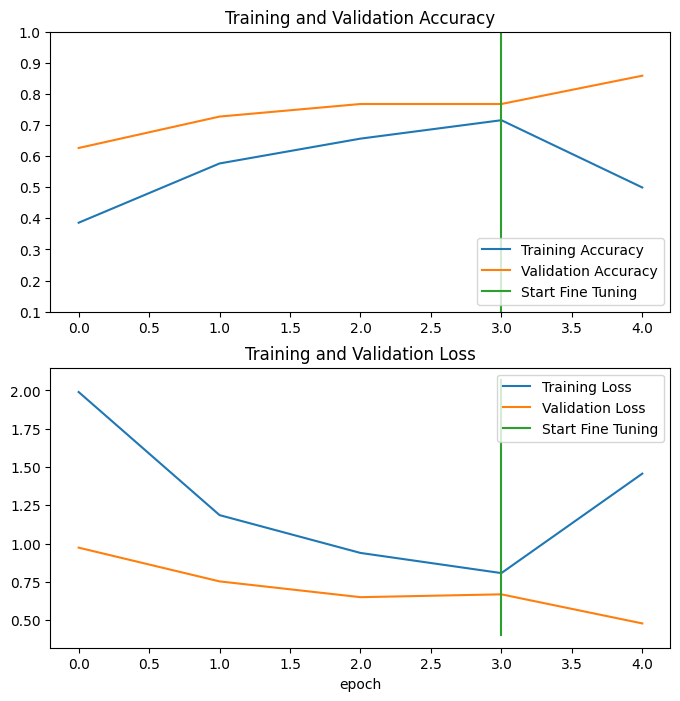

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1]) # set the y-axis limits
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step - accuracy: 0.8056 - loss: 0.7575


[0.6419306397438049, 0.8333333134651184]

Predictions:
 [1 5 1 5 0 2 0 2 5 3 2 5]
Labels:
 [1 5 4 5 0 2 0 2 5 3 2 5]


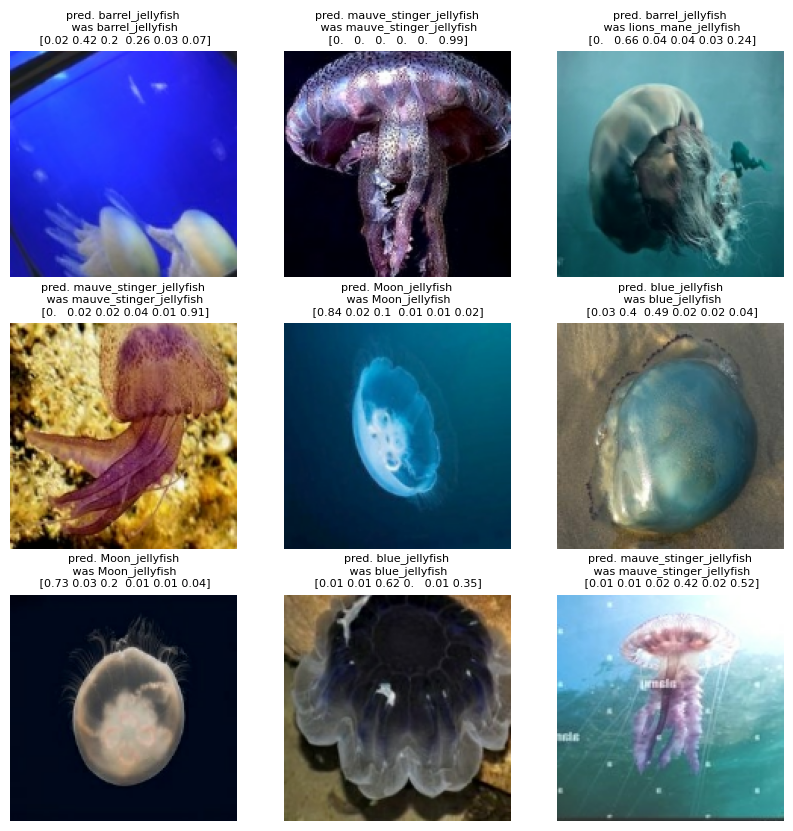

In [20]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions_in_percentage = model.predict_on_batch(image_batch)
# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = np.argmax(predictions_in_percentage, axis=-1)
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('pred. ' + class_names[predictions[i]] + "\n" + ' was ' + class_names[label_batch[i]] + "\n" + ' ' + 	str(np.round(predictions_in_percentage[i], 2)), fontsize=8)
  plt.axis("off")

In [1]:
model.save('Jellyfish_InceptionResNetV2_transferlearning.keras')

NameError: name 'model' is not defined